In [1]:
#Librerias

import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import warnings # supress warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from scipy.stats import norm

import math

In [2]:
#Conexión con Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Lectura desde pc (comentada) o desde Drive

#DatosCovid=pd.read_csv(r'D:\Descargas\DS\Covid\owid-covid-data.csv')
#DatosMedida=pd.read_csv(r'D:\Descargas\DS\Covid\stay-at-home-covid.csv')
DatosCovid=pd.read_csv(r'/content/drive/MyDrive/owid-covid-data.csv')
DatosMedida=pd.read_csv(r'/content/drive/MyDrive/stay-at-home-covid.csv')

# Exploración del Dataset

In [4]:
DatosCovid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [5]:
DatosCovid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205921 entries, 0 to 205920
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    205921 non-null  object 
 1   continent                                   194015 non-null  object 
 2   location                                    205921 non-null  object 
 3   date                                        205921 non-null  object 
 4   total_cases                                 197555 non-null  float64
 5   new_cases                                   197305 non-null  float64
 6   new_cases_smoothed                          196128 non-null  float64
 7   total_deaths                                178797 non-null  float64
 8   new_deaths                                  178772 non-null  float64
 9   new_deaths_smoothed                         177605 non-null  float64
 

In [6]:
DatosCovid.shape

(205921, 67)

In [7]:
# Cuenta cantidad de países
len(DatosCovid.location.unique())

244

In [8]:
# Quitamos la forma logaritmica para poder leer mejor las poblaciones
pd.options.display.float_format = '{:.2f}'.format

In [9]:
Poblacion = DatosCovid.drop_duplicates(subset=['location', 'population'])
Poblacion = Poblacion.loc[:,['location', 'population']]
Poblacion = Poblacion.drop([202418, 9784, 108798,195790,86686,138276,59522,891,80394,60445,135653,107906,171170,170262],axis=0) # se dropean continentes y demás
Poblacion.reset_index(drop=True)
Poblacion.sort_values(by='population', ascending=True)

,location,population
148440,Pitcairn,47.00
199089,Vatican,511.00
185395,Tokelau,1849.00
135387,Niue,1937.00
62250,Falkland Islands,3764.00
...,...,...
141905,Pakistan,231402116.00
85802,Indonesia,273753191.00
194048,United States,336997624.00
84886,India,1407563842.00


# Seleccion de paises

Se procederá a clusterizar (con Kmeans) los países por cantidad de población y en base a ello se tomará una decisión sobre cuales trabajar

In [10]:
Poblacion.groupby('location').sum().shape[0]

230

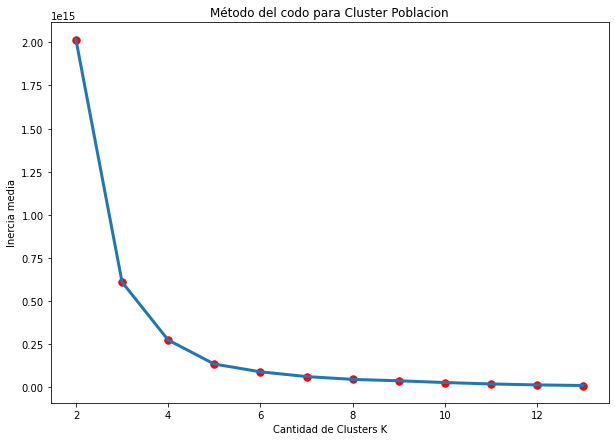

In [11]:
Sum_of_squared_distances = []
K = np.arange(2,14)
# Fiteammos un modelo para cada numero de cluster que queremos testear
for k in K:
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(Poblacion.groupby('location').sum())
    # Calculamos la distancia media y agregamos a la lista
    distancia_total = km.inertia_
    distancia_media = np.divide(distancia_total,Poblacion.groupby('location').sum().shape[0])
    Sum_of_squared_distances.append(distancia_media)
    
plt.figure(figsize = (10,7))
plt.plot(K, Sum_of_squared_distances, lw=3)
plt.scatter(K, Sum_of_squared_distances,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Inercia media')
plt.title('Método del codo para Cluster Poblacion')

plt.show()

Según el codo la cantidad de Clusters óptimos es de 5

In [12]:
Cluster = KMeans(n_clusters=5, n_init=25,max_iter=3000)
Cluster.fit(Poblacion.groupby('location').sum())

KMeans(max_iter=3000, n_clusters=5, n_init=25)

In [13]:
y_predict = Cluster.predict(Poblacion.groupby('location').sum())

In [14]:
Poblacion['cluster'] = Cluster.labels_
Poblacion.sort_values(by='cluster', ascending=False)

,location,population,cluster
0,Afghanistan,40099462.00,4
146644,Peru,33715472.00,4
182707,Thailand,71601103.00,4
181837,Tanzania,63588334.00,4
180083,Taiwan,23859912.00,4
...,...,...,...
79528,Haiti,11447569.00,0
81318,Honduras,10278346.00,0
82193,Hong Kong,7494578.00,0
83116,Hungary,9709786.00,0


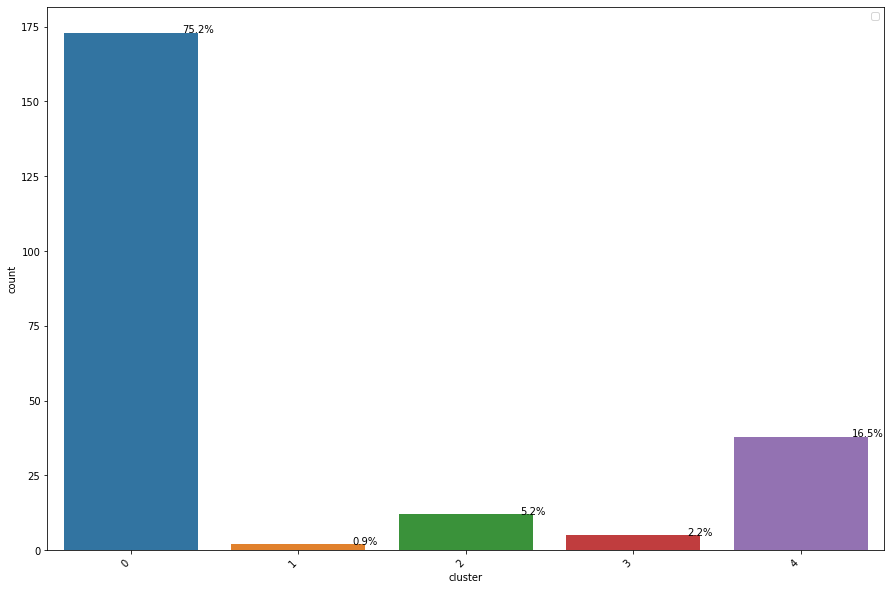

In [15]:
total = float(len(Poblacion))
plt.figure(figsize = (15,10))
ax = sns.countplot(Poblacion['cluster'], data= Poblacion)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.legend(loc = 'upper right')
plt.xticks(rotation = 45, horizontalalignment="right")
plt.show()

In [16]:
Y = Poblacion.population
X = Poblacion.cluster

Text(0, 0.5, 'POPULATION')

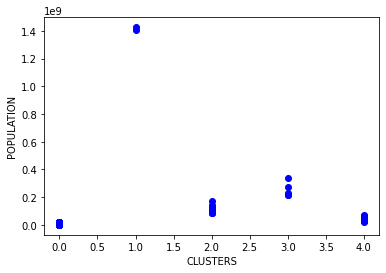

In [17]:
plt.scatter(X,Y, c='blue')
plt.xlabel("CLUSTERS")
plt.ylabel("POPULATION")

In [18]:
df_mask = Poblacion['cluster']==1
filtered_df = Poblacion[df_mask]
filtered_df

,location,population,cluster
37978,China,1425893464.00,1
84886,India,1407563842.00,1


In [19]:
agrupado = Poblacion.groupby(['cluster']).agg(
                                  {'population': 'sum', 
                                   'location': 'count'
#                                   ,'population': 'mean'
                                  }).reset_index()
agrupado = agrupado.sort_values(by='population', ascending=True)
agrupado = agrupado.assign(Porcentaje= agrupado['population']/1830133587*100)
agrupado

,cluster,population,location,Porcentaje
0,0,866612480.00,173,47.35
3,3,1269880477.00,5,69.39
2,2,1358671742.00,12,74.24
4,4,1565481166.00,38,85.54
1,1,2833457306.00,2,154.82


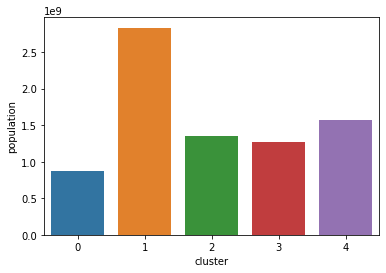

In [20]:
sns.barplot(data=agrupado, x='cluster', y='population')

Se eligirán 2 paises por cluster, teniendo en cuenta que sean de diferentes partes del mundo y se tendrá en cuenta el promedio de habitantes para el Cluster 0 y 4 que son los que más países tienen.

cluster	Promedio	
	0	5009320.69	
	4	41196872.79	


Países Elegidos:



*   Cluster 0: Costa Rica y Noruega
*   Cluster 1: China e India
*   Cluster 2: Estados Unidos y Nigeria
*   Cluster 3: Japon y Mexico
*   Cluster 4: Argentina e Irak







In [21]:
Paises_selec = ['Costa Rica','Iraq','Argentina','Norway','China','India','Japan','Mexico','United States','Nigeria']

In [22]:
paises=DatosCovid['location'] #cargo el vector de paises
confirmados=DatosCovid['total_cases'] #carga vector todos los casos confirmados

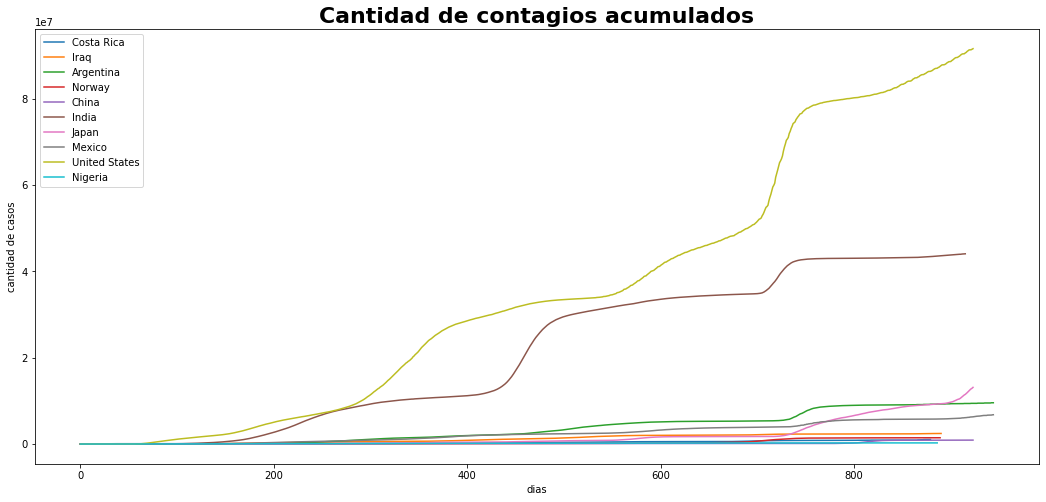

In [23]:
plt.figure(figsize=(18,8))
for i in Paises_selec:

  lista = []
  ind = np.where(paises==i)
  ind = ind[0]
  casos = confirmados[ind]
  dias = np.arange(0,len(casos))
  plt.title("Cantidad de contagios acumulados", fontsize=22, fontweight ="bold")
  plt.plot(dias,casos, label=i)
  plt.xlabel('dias')
  plt.ylabel('cantidad de casos')
  plt.legend(loc=0)

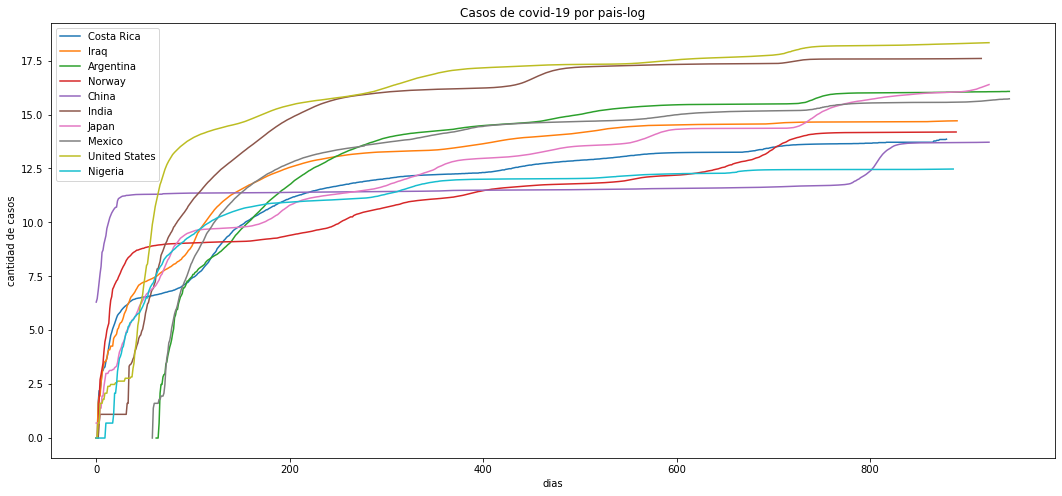

In [24]:
plt.figure(figsize=(18,8))
for i in Paises_selec:
    ind_=np.where(paises==i)
    ind_=ind_[0]
    casos_=confirmados[ind_]
    dias=np.arange(0,len(casos_))

    plt.plot(dias,np.log(casos_),label=i)
    plt.title("Casos de covid-19 por pais-log")
    plt.xlabel('dias')
    plt.ylabel('cantidad de casos')
    plt.grid()
    plt.legend()

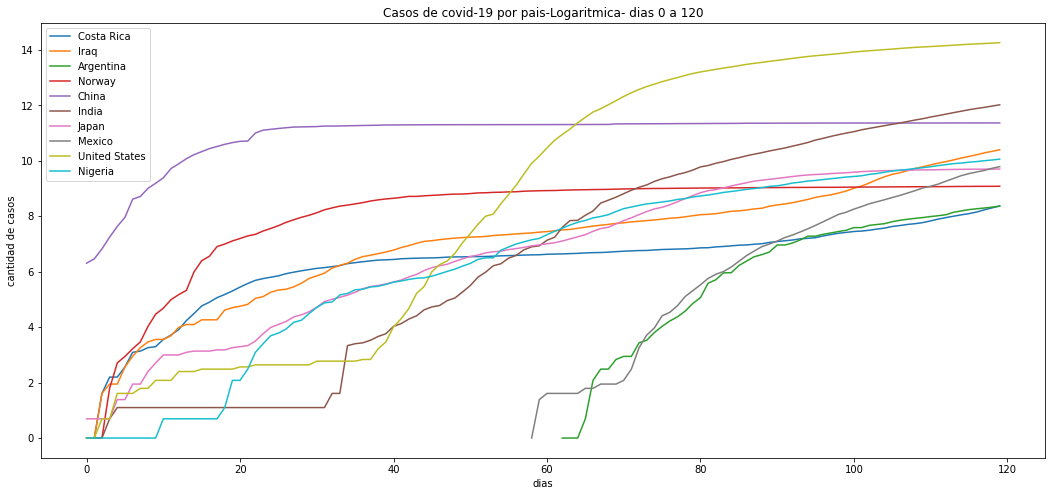

In [25]:
plt.figure(figsize=(18,8))
for i in Paises_selec:
    ind_=np.where(paises==i)
    ind_=ind_[0]
    casos_=confirmados[ind_]
    casos_principio=casos_[0:120]
    dias_principio=dias[0:120]

    plt.plot(dias_principio,np.log(casos_principio),label=i)
    plt.title("Casos de covid-19 por pais-Logaritmica- dias 0 a 120")
    plt.xlabel('dias')
    plt.ylabel('cantidad de casos')
    plt.grid()
    plt.legend()

In [26]:
DiaCom = [1,1,65,1,1,40,20,70,40,20]
DiaFin= [20,30,90,20,20,60,40,90,60,40]

In [27]:
#DataPais = pd.DataFrame(list(zip(Paises_selec,DiaCom,DiaFin)), columns = ['Pais','t0','tf'])
DataPais = pd.DataFrame({"Pais":Paises_selec, "t0":DiaCom,"tf":DiaFin})

In [28]:
def puntajes(X_test, X_train, y_test, y_test_pred, model):
  print("AC SCORE TRAIN:",accuracy_score(y_train, y_train_pred))
  print("AC SCORE TEST:",accuracy_score(y_test, y_test_pred))
  print("F1 SCORE: ", (f1_score(y_test, y_test_pred, average="weighted")))
  plot_confusion_matrix(model, X_test, y_test, values_format=".0f") 

def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

def casos_nuevos(casos):
  nuevos=np.zeros(len(casos))
  i=0
  while i<len(nuevos)-1:
    nuevos[i]=casos[i+1]-casos[i]
    i=i+1

  return nuevos

def bootstrap_simplificado(dataset, B=100):
    boots = []
    for _ in range(B):
        boots.append(np.random.choice(dataset, size=len(dataset)))
    return np.array(boots)

In [29]:
def info_pais (pais, t0, tf):

    ind=np.where(paises==pais)
    ind=ind[0]
    casos=confirmados[ind]
    dias=np.arange(0,len(casos))

    casos_principio=casos[t0:tf]
    dias_principio=dias[t0:tf]

    #ajustamos ---- scipy.optimize.curve_fit(f, xdata, ydata)
    popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)

    k=popt[0]
    t0_=popt[1]
    casos_simu=exponencial(dias_principio,k,t0_)

    dic = {"Pais": pais , "t0":[t0], "t":[tf], "k": [k]}
    datos_pais = pd.DataFrame(data=dic)
    return datos_pais

In [30]:
def graf_pais (pais, t0, tf):

    ind=np.where(paises==pais)
    ind=ind[0]
    casos=confirmados[ind]
    dias=np.arange(0,len(casos))

    casos_principio=casos[t0:tf]
    dias_principio=dias[t0:tf]

    #ajustamos ---- scipy.optimize.curve_fit(f, xdata, ydata)
    popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)

    k=popt[0]
    t0_=popt[1]
    casos_simu=exponencial(dias_principio,k,t0_)

    dic = {"Pais": pais , "t0":[t0], "t":[tf], "k": [k]}
    datos_pais = pd.DataFrame(data=dic)

    
    plt.figure(figsize=(20,5))
    plt.suptitle(pais, fontsize=22, fontweight="bold")
    

    plt.subplot(1,3,1)
    plt.plot(dias_principio,casos_principio)
    plt.title("Curva de contagio")
    plt.xlabel('dias')
    plt.ylabel('cantidad de casos')

    plt.subplot(1,3,2)
    plt.plot(dias_principio,np.log(casos_principio))
    plt.title("Logaritmo de la curva de contagio")
    plt.xlabel('dias')
    plt.ylabel('log cantidad de casos')

    plt.subplot(1,3,3)
    plt.title("Prediccion del modelo")
    plt.plot(dias_principio,casos_principio,'.')
    plt.plot(dias_principio,casos_simu)
    plt.xlabel('dias')
    plt.ylabel('cantidad de casos')
    
    plt.tight_layout()

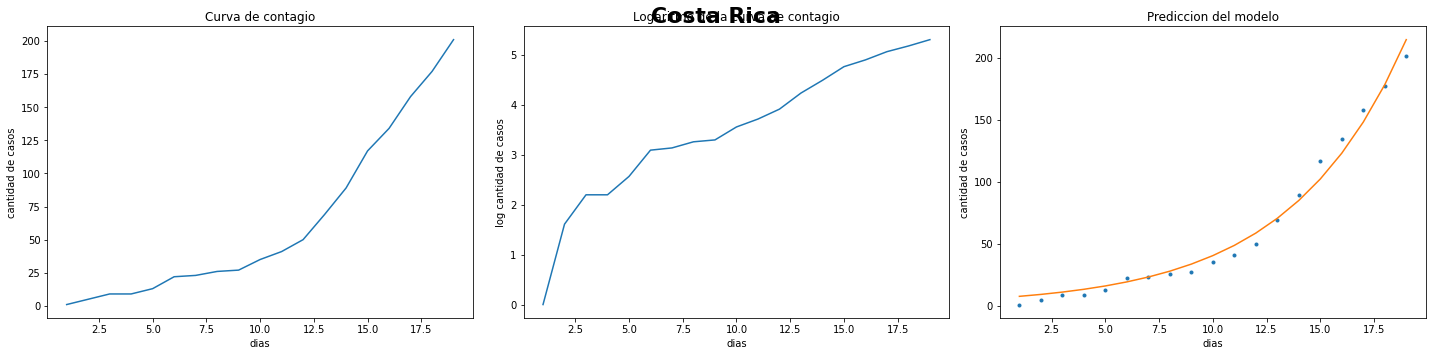

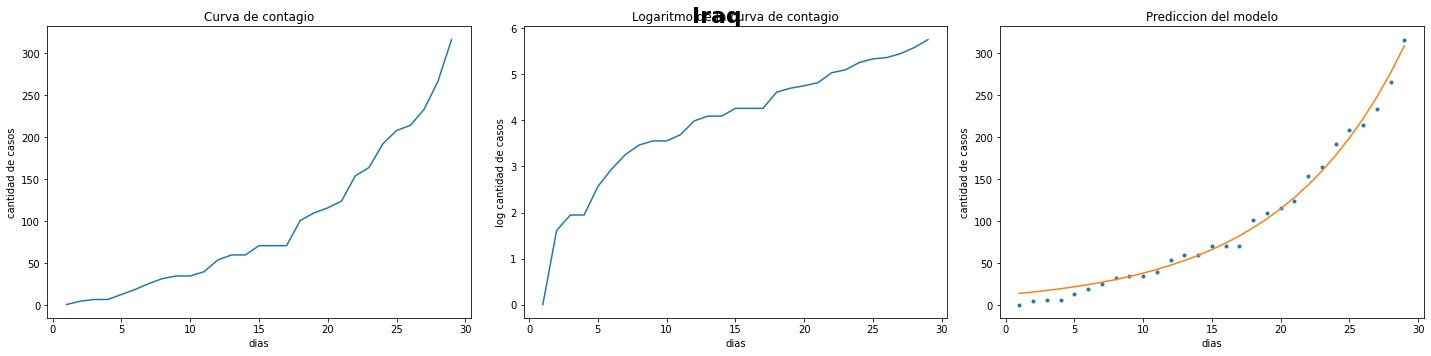

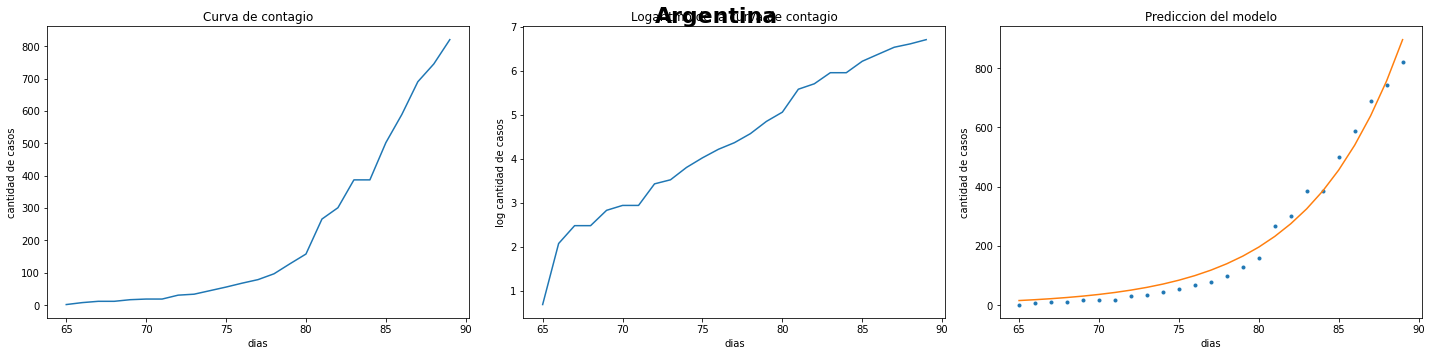

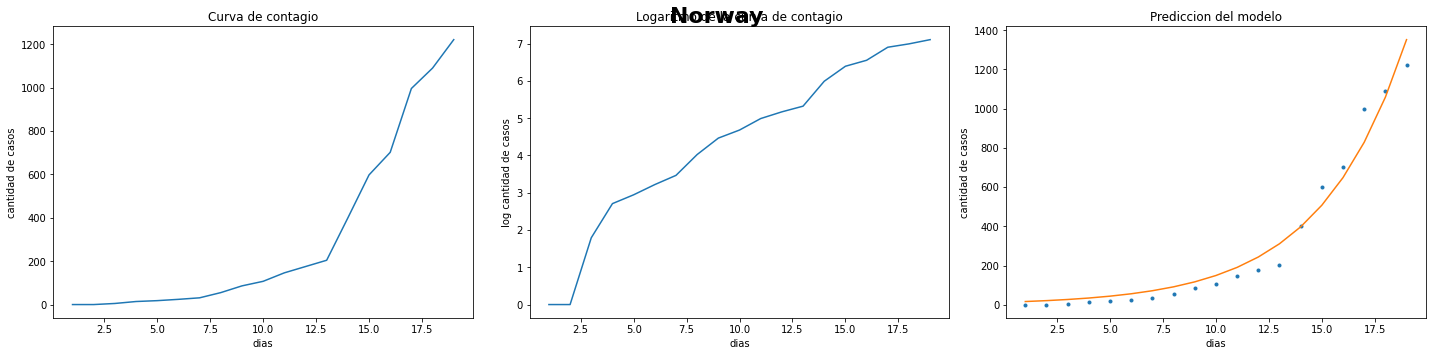

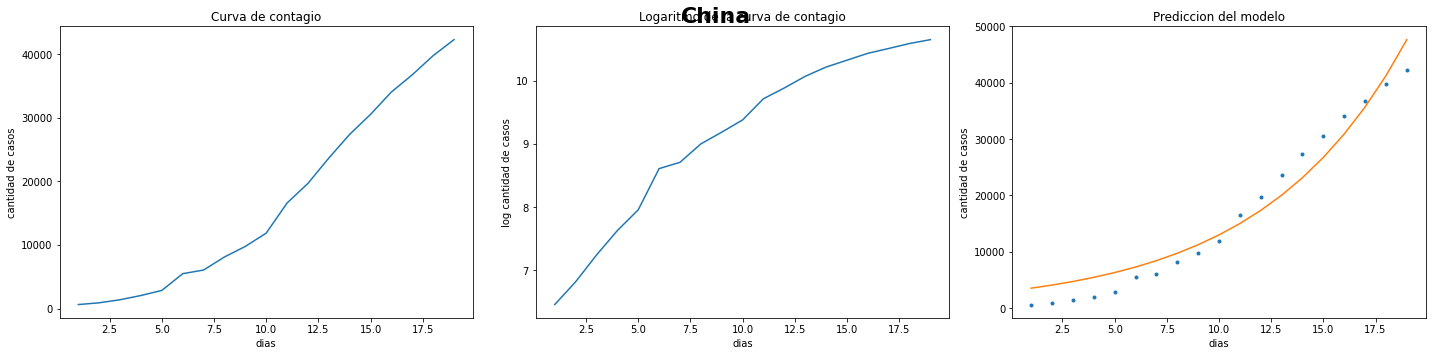

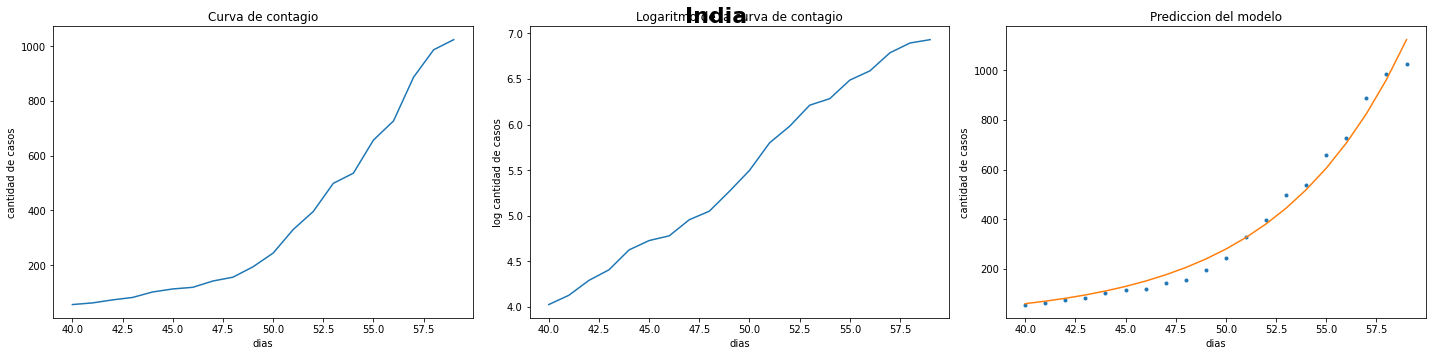

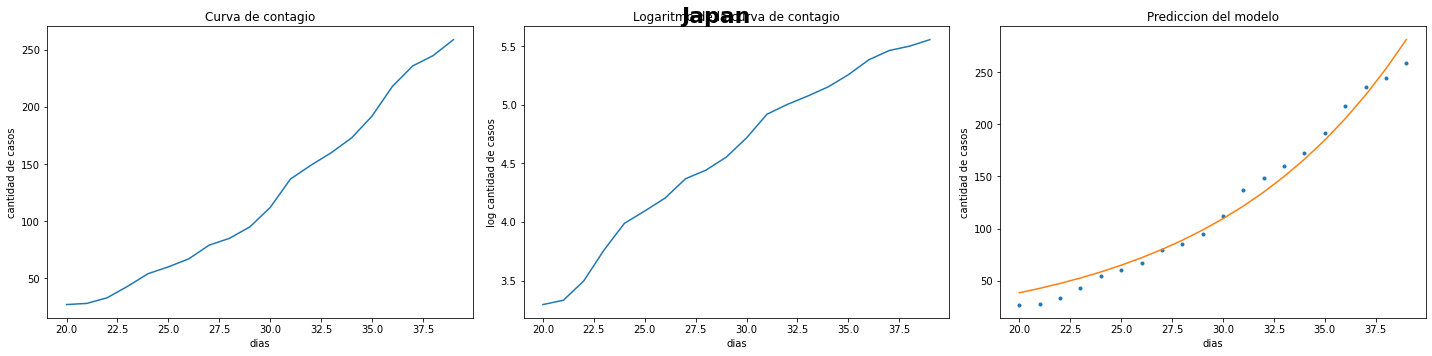

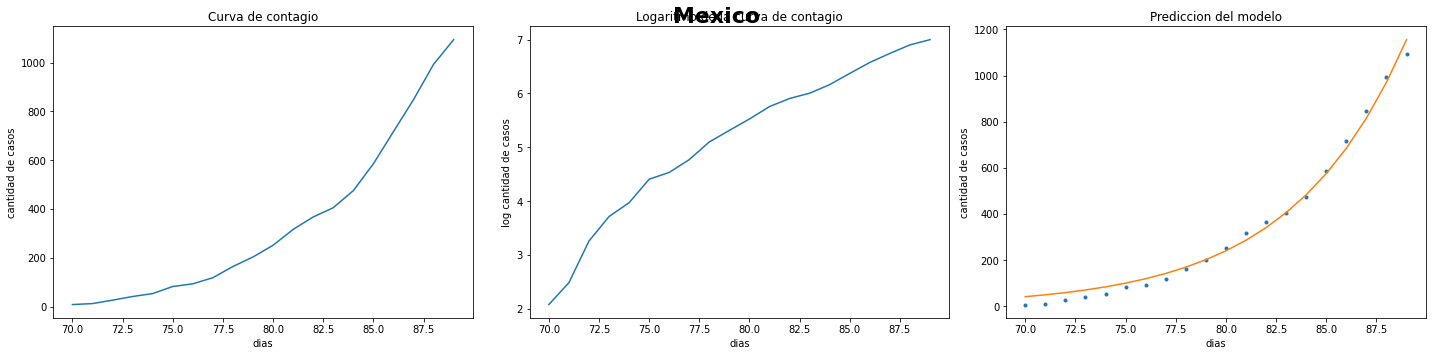

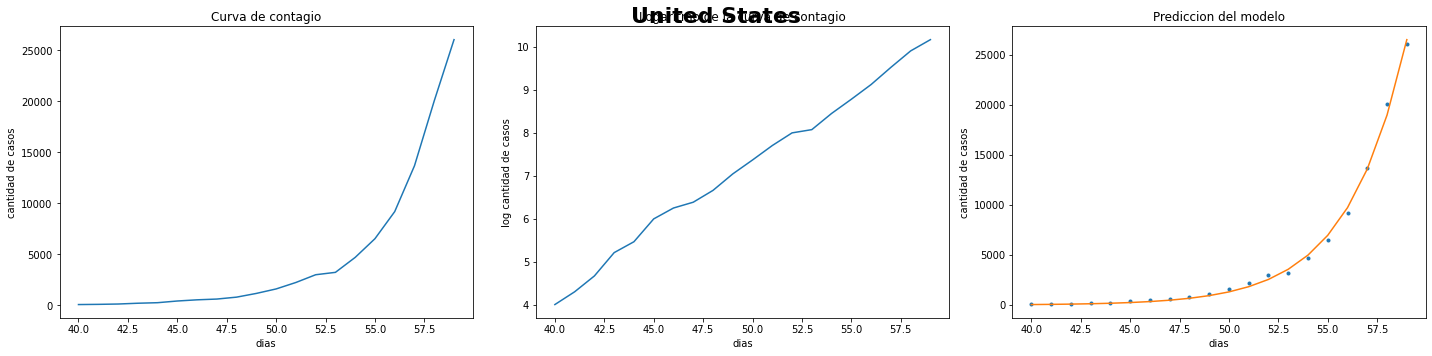

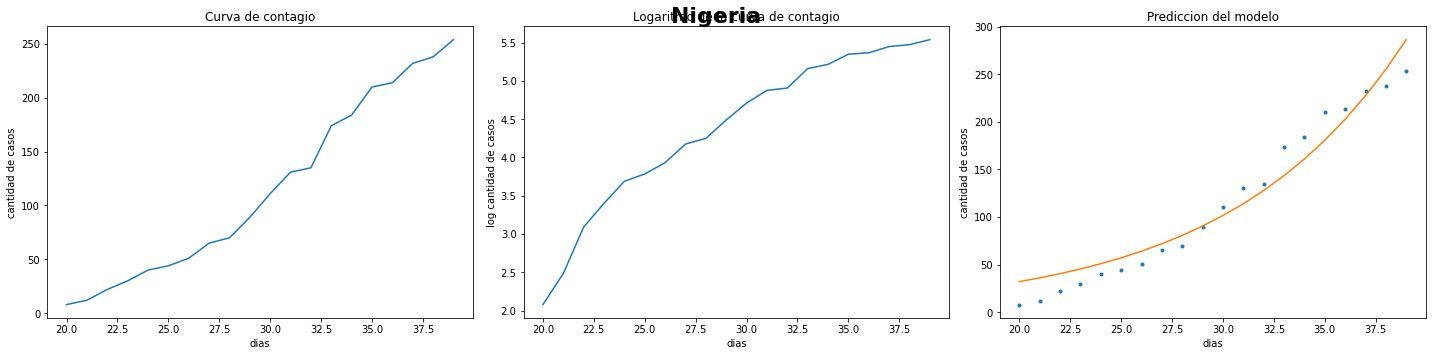

In [31]:
for i in range(len(DataPais)):
    graf_pais(DataPais.iloc[i].Pais, DataPais.iloc[i].t0, DataPais.iloc[i].tf)

In [32]:
list = []

for i in range(len(DataPais)):

    df = info_pais(DataPais.iloc[i].Pais, DataPais.iloc[i].t0, DataPais.iloc[i].tf)
    list.append(df)

DataPais = pd.concat(list)
DataPais

,Pais,t0,t,k
0,Costa Rica,1,20,0.19
0,Iraq,1,30,0.11
0,Argentina,65,90,0.17
0,Norway,1,20,0.24
0,China,1,20,0.14
0,India,40,60,0.15
0,Japan,20,40,0.10
0,Mexico,70,90,0.17
0,United States,40,60,0.33
0,Nigeria,20,40,0.12


In [33]:
val_k = DataPais.k
val_k

0   0.19
0   0.11
0   0.17
0   0.24
0   0.14
0   0.15
0   0.10
0   0.17
0   0.33
0   0.12
Name: k, dtype: float64

In [34]:
# Obtenemos valores estadisticos

print(f"Media de k: { val_k.mean() }")
print(f"Mediana de k: { val_k.median() }")
print(f"Desvio estandar de k: { val_k.std() }")

Media de k: 0.17365844019023757
Mediana de k: 0.16175186525925056
Desvio estandar de k: 0.0702741094095241


Text(0.5, 1.0, 'Distribucion de densidad de k')

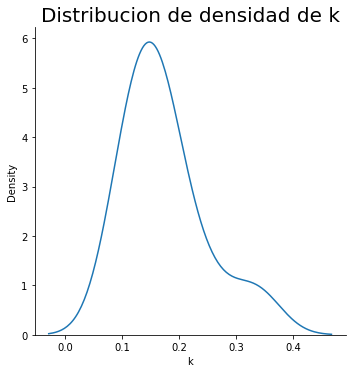

In [35]:
sns.displot(val_k, kind="kde")
plt.title("Distribucion de densidad de k", fontsize=20)

k_final=0.17345577491851266


Text(0, 0.5, 'Muestras')

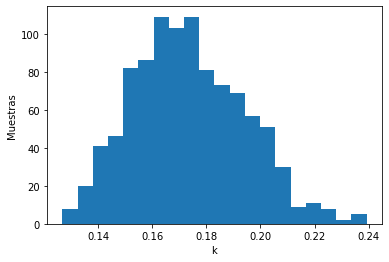

In [36]:
# Bootstrapping

datos_boots = bootstrap_simplificado(val_k,1000)
alpha = 1
medias = np.apply_along_axis(func1d=np.mean, axis=1, arr=datos_boots)
medias.sort()
k_final = medias.mean()
print(f"k_final={medias.mean()}")
plt.hist(medias, bins=20)
plt.xlabel("k")
plt.ylabel("Muestras")

In [37]:
# Construccion del intervalo de confianza
inferior = np.percentile(medias, alpha/2)
superior = np.percentile(medias, (100-alpha/2))
intervalo_confianza = [inferior, superior]
print(f"Con una certeza del 95% el valor del k promedio se encuentra en el intervalo: {intervalo_confianza}")

Con una certeza del 95% el valor del k promedio se encuentra en el intervalo: [0.1296627668771938, 0.23303262647214498]


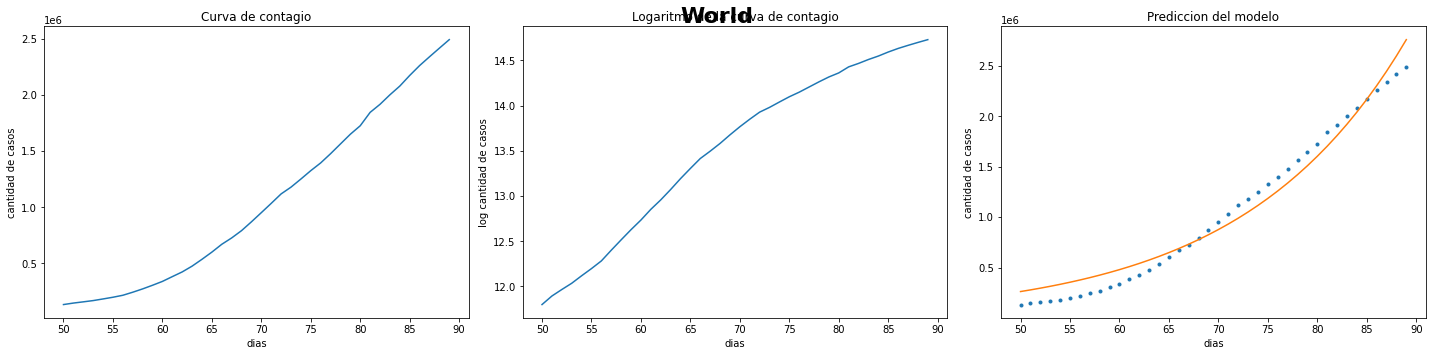

In [38]:
graf_pais("World", 50, 90)

In [39]:
info_pais("World", 50, 90)

,Pais,t0,t,k
0,World,50,90,0.06


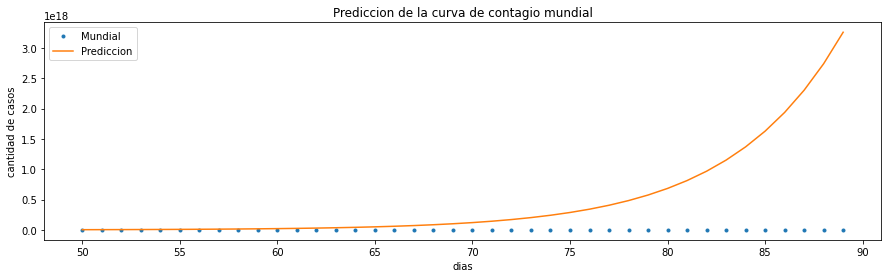

In [40]:
# Probamos el k promedio que habiamos calculado para predecir el comportamiento de la curva de contagio mundial.

ind_world=np.where(paises=='World')
ind_world=ind_world[0]
casos_world=confirmados[ind_world]
casos_principio=casos_world[50:90]
dias_principio=dias[50:90]
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)

k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)


casos_simu=exponencial(dias_principio,k_final,t0)

plt.figure(figsize=(15,4))
plt.plot(dias_principio,casos_principio,'.', label="Mundial")
plt.plot(dias_principio,casos_simu, label="Prediccion")
plt.title("Prediccion de la curva de contagio mundial")
plt.xlabel('dias') 
plt.ylabel('cantidad de casos')
plt.legend()

El modelo para el mundo es muy malo, esto es porque en distintos países el virus se combatió de diferentes formas, y países que en los primeros días no estaban precabidos, si lo estuvieron a medida que fue avanzando a través del mapa el Covid

# ELECCION MEDIDA SANITARIA

Elegiremos países que decidieron no hacer cuarentena VS países que si la han hecho. Sé intentará tomar el mismo parametro elegido anteriormente y comparar países con poblaciones similares entre ellos y ver como varía o no las medidas entre países de distintos clusters

Info:

https://ourworldindata.org/covid-stay-home-restrictions

Stay at home:

0 - No measures

1 - recommend not leaving house

2 - require not leaving house with exceptions for daily exercise, grocery shopping, and ‘essential’ trips

3 - Require not leaving house with minimal exceptions (e.g. allowed to leave only once every few days, or only one person can leave at a time, etc.)

In [41]:
DatosMedida

,Entity,Code,Day,stay_home_requirements
0,Afghanistan,AFG,2020-01-01,0
1,Afghanistan,AFG,2020-01-02,0
2,Afghanistan,AFG,2020-01-03,0
3,Afghanistan,AFG,2020-01-04,0
4,Afghanistan,AFG,2020-01-05,0
...,...,...,...,...
173213,Zimbabwe,ZWE,2022-07-04,2
173214,Zimbabwe,ZWE,2022-07-05,2
173215,Zimbabwe,ZWE,2022-07-06,2
173216,Zimbabwe,ZWE,2022-07-07,2


In [42]:
Paises_selec.append('Ethiopia')

In [43]:
Paises_selec.remove('Nigeria')

In [44]:
DatosMedida2 = DatosMedida.groupby(['Entity','stay_home_requirements'])['stay_home_requirements'].agg(['count']).reset_index()

In [45]:
DatosMedida2

,Entity,stay_home_requirements,count
0,Afghanistan,0,765
1,Afghanistan,2,167
2,Afghanistan,3,6
3,Albania,0,203
4,Albania,1,206
...,...,...,...
588,Zambia,1,177
589,Zambia,2,23
590,Zimbabwe,0,82
591,Zimbabwe,1,122


In [46]:
DatosMedida3 =DatosMedida2[DatosMedida2.Entity.isin(Paises_selec)] 
DatosMedida3

,Entity,stay_home_requirements,count
15,Argentina,0,266
16,Argentina,1,97
17,Argentina,2,522
18,Argentina,3,39
113,China,0,51
114,China,1,157
115,China,2,60
116,China,3,675
125,Costa Rica,0,213
126,Costa Rica,1,730


In [47]:
DatosMedida4 = DatosMedida.rename(columns={'Day':'date',
                                            'Entity' : 'location'
})
DatosMedida4 = DatosMedida4.drop(['Code'], axis=1)

In [48]:
DatosMedida4 = DatosMedida4[(DatosMedida4.date < "2022-07-01")]

In [49]:
DatosMedida4

,location,date,stay_home_requirements
0,Afghanistan,2020-01-01,0
1,Afghanistan,2020-01-02,0
2,Afghanistan,2020-01-03,0
3,Afghanistan,2020-01-04,0
4,Afghanistan,2020-01-05,0
...,...,...,...
173205,Zimbabwe,2022-06-26,2
173206,Zimbabwe,2022-06-27,2
173207,Zimbabwe,2022-06-28,2
173208,Zimbabwe,2022-06-29,2


United States	tuvo cuarentena inteligente, dependiendo de los estados. Se elige colocarlo en el grupo sin cuarentena.

Lamentablemente del Cluster del cuál es parte Nigeria ningún país(exceptuando EEUU ha realizado cuarentena).
Y el caso de Nigeria es confuso, en la web aparece como si no hubiera hecho cuarentena pero al ver la tabla, tiene muchisimos días en 2, es decir "permanecer en casa".
 El país más cercano en población y que no hizo cuarentena es Ethiopia, por tanto lo elegiremos a este

## Indicadores

**new_cases_smoothed_per_million** = Nuevos casos de COVID-19 (Media movil de 7 dias) por 1,000,000 habitantes. El contado incluye casos probables cuando son reportados.

**reproduction_rate** = Estimación en tiempo real del R (factor de reproduccion) efectivo del COVID-19

**stringency_index** = Indice de Rigurosidad de la Respuesta del Gobierno: es una medida compuesta basada en 9 indicadores que incluyen: cierres de escuelas, cierres de espacios de trabajo, prohibicion del transporte publico, etc. Esta reescalado a un valor entre 0 y 100, siendo 100 el valor de mas estricto. 

In [50]:
DatosIND = DatosCovid[(DatosCovid.location.isin(Paises_selec)) & (DatosCovid.date < "2022-07-01")]
DatosIND = DatosIND[["location","date","new_cases_smoothed_per_million","reproduction_rate","total_deaths_per_million","stringency_index","hosp_patients_per_million"]]
DatosIND

,location,date,new_cases_smoothed_per_million,reproduction_rate,total_deaths_per_million,stringency_index,hosp_patients_per_million
7054,Argentina,2020-01-01,NaN,NaN,NaN,0.00,NaN
7055,Argentina,2020-01-02,NaN,NaN,NaN,0.00,NaN
7056,Argentina,2020-01-03,NaN,NaN,NaN,0.00,NaN
7057,Argentina,2020-01-04,NaN,NaN,NaN,0.00,NaN
7058,Argentina,2020-01-05,NaN,NaN,NaN,0.00,NaN
...,...,...,...,...,...,...,...
194934,United States,2022-06-26,306.11,1.09,3015.16,26.49,83.45
194935,United States,2022-06-27,334.62,1.09,3016.05,26.49,86.45
194936,United States,2022-06-28,328.42,1.07,3017.73,26.48,87.69
194937,United States,2022-06-29,330.48,1.06,3019.91,26.48,88.85


Text(0.5, 1.0, 'Correlacion entre los indicadores')

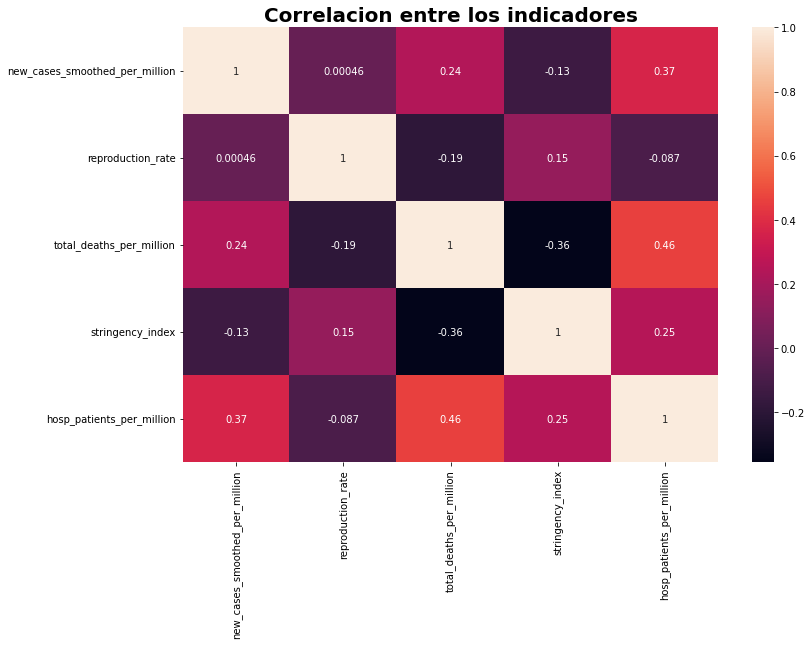

In [51]:
# Analisis de Correlacion entre los indicadores 

corr_df = DatosIND.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_df, annot=True)
plt.title("Correlacion entre los indicadores", fontsize=20, fontweight="bold")

In [52]:
result = pd.merge(DatosIND, DatosMedida4, on=["location", "date"])
result.date = pd.to_datetime(result.date)

In [53]:
result

,location,date,new_cases_smoothed_per_million,reproduction_rate,total_deaths_per_million,stringency_index,hosp_patients_per_million,stay_home_requirements
0,Argentina,2020-01-01,NaN,NaN,NaN,0.00,NaN,0
1,Argentina,2020-01-02,NaN,NaN,NaN,0.00,NaN,0
2,Argentina,2020-01-03,NaN,NaN,NaN,0.00,NaN,0
3,Argentina,2020-01-04,NaN,NaN,NaN,0.00,NaN,0
4,Argentina,2020-01-05,NaN,NaN,NaN,0.00,NaN,0
...,...,...,...,...,...,...,...,...
8777,United States,2022-06-26,306.11,1.09,3015.16,26.49,83.45,0
8778,United States,2022-06-27,334.62,1.09,3016.05,26.49,86.45,0
8779,United States,2022-06-28,328.42,1.07,3017.73,26.48,87.69,0
8780,United States,2022-06-29,330.48,1.06,3019.91,26.48,88.85,0


In [54]:
# Se modifica los valores de cuarentena para poder realizar luego el modelo, los valores de stay_home_requirements 1 y 0 serán 0 (sin cuarentena), los 2 y 3 serán 1 (cuarentena)

result.stay_home_requirements.replace(1,0, inplace=True)
result.stay_home_requirements.replace([3,2],1, inplace=True)

In [55]:
result = result.fillna(0)
result = result.rename(columns={'stay_home_requirements':'Cuarentena'
})
result

,location,date,new_cases_smoothed_per_million,reproduction_rate,total_deaths_per_million,stringency_index,hosp_patients_per_million,Cuarentena
0,Argentina,2020-01-01,0.00,0.00,0.00,0.00,0.00,0
1,Argentina,2020-01-02,0.00,0.00,0.00,0.00,0.00,0
2,Argentina,2020-01-03,0.00,0.00,0.00,0.00,0.00,0
3,Argentina,2020-01-04,0.00,0.00,0.00,0.00,0.00,0
4,Argentina,2020-01-05,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...
8777,United States,2022-06-26,306.11,1.09,3015.16,26.49,83.45,0
8778,United States,2022-06-27,334.62,1.09,3016.05,26.49,86.45,0
8779,United States,2022-06-28,328.42,1.07,3017.73,26.48,87.69,0
8780,United States,2022-06-29,330.48,1.06,3019.91,26.48,88.85,0


Costa Rica

In [56]:
CostaRica = result[(result.location.isin(['Costa Rica']))]
CostaRica = CostaRica.set_index('date')


Text(0.5, 0, 'fecha')

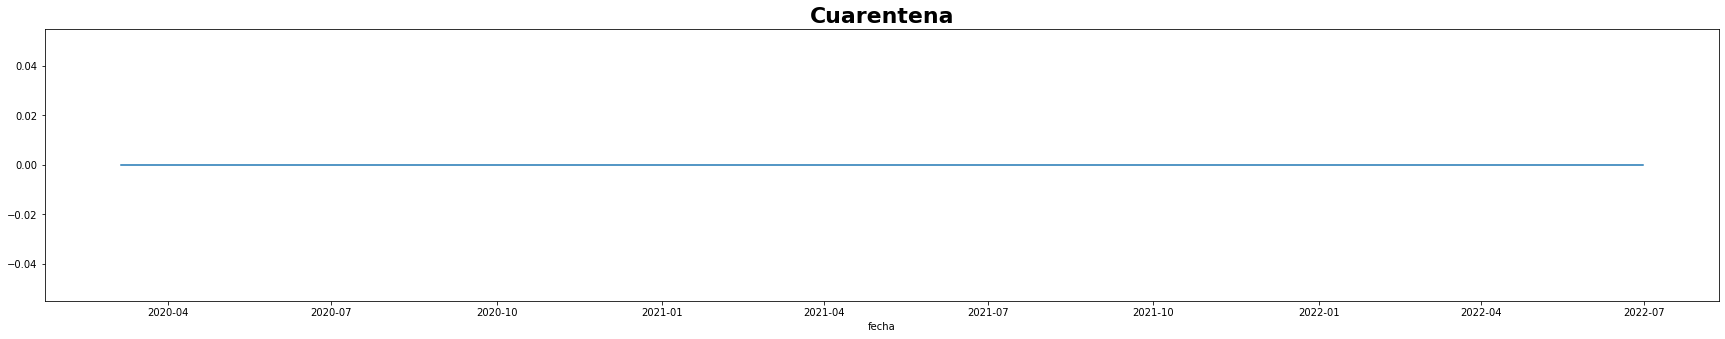

In [57]:
plt.figure(figsize=(30,5))
plt.plot(CostaRica.Cuarentena)
plt.title("Cuarentena", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

# Argentina

In [58]:
Argentina = result[(result.location.isin(['Argentina']))]
Argentina = Argentina.set_index('date')

Text(0.5, 0, 'fecha')

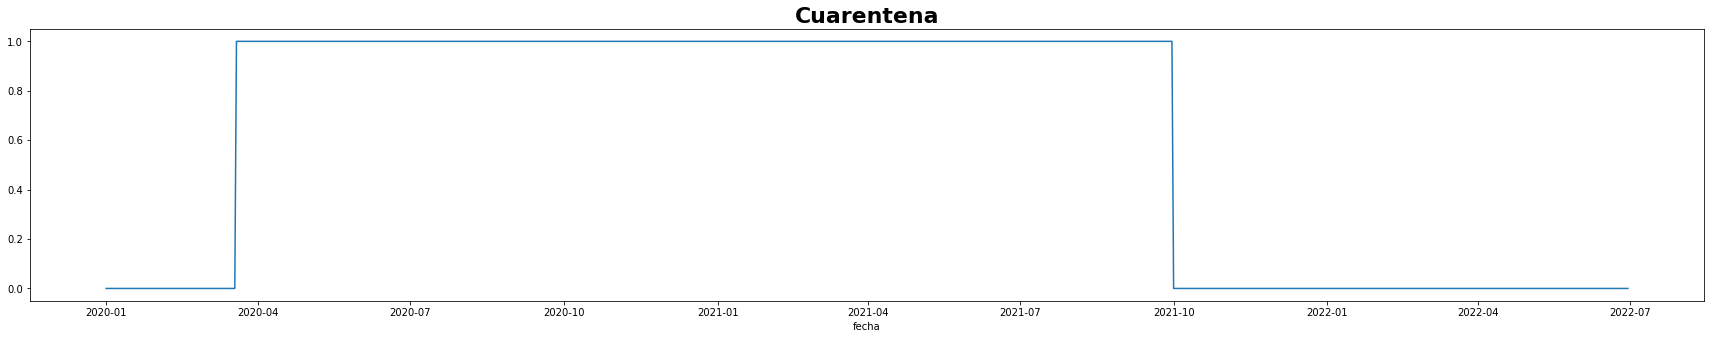

In [59]:
plt.figure(figsize=(30,5))
plt.plot(Argentina.Cuarentena)
plt.title("Cuarentena", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Modelo

In [60]:
Argentina = Argentina.drop(columns=["location"])

In [61]:
X = Argentina.drop(columns=["Cuarentena"])
y = Argentina.Cuarentena

In [62]:
logreg = LogisticRegression()

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

In [64]:
#  penalty — Specify the norm of the penalty.
#  C — Inverse of regularization strength; smaller values specify stronger regularization.
#  solver — Algorithm to use in the optimization problem.
#  max_iter — Maximum number of iterations taken for the solvers to converge.

# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [65]:
model = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [66]:
model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [67]:
print("Tuned Hyperparameters :", model.best_params_)
print("Accuracy :",model.best_score_)

Tuned Hyperparameters : {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 1.0


In [68]:
logreg = LogisticRegression(**model.best_params_)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.001, solver='newton-cg')

In [69]:
y_test_pred = logreg.predict(X_test)
y_train_pred = logreg.predict(X_train)

AC SCORE TRAIN: 1.0
AC SCORE TEST: 1.0
F1 SCORE:  1.0


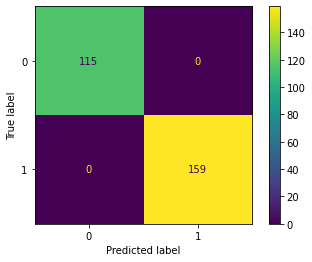

In [70]:
puntajes(X_test, X_train, y_test, y_test_pred, logreg)

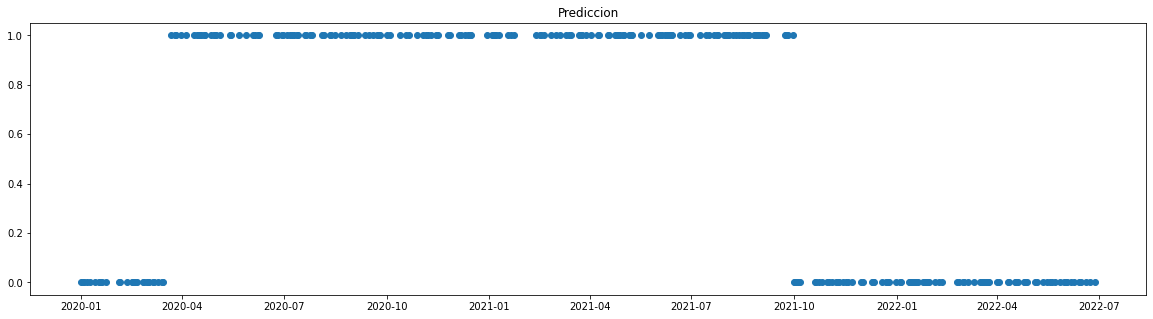

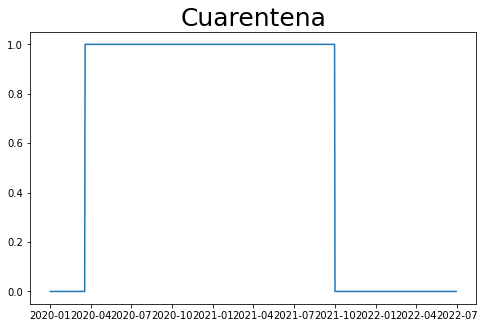

In [71]:
plt.figure(figsize=(20,5))
plt.scatter(X_test.index, y_test_pred)
plt.title("Prediccion")

plt.figure(figsize=(8,5))
plt.title("Cuarentena", fontsize=25)
plt.plot(Argentina.Cuarentena)

In [72]:
score_arg = logreg.score(X_test, y_test)
w0 = logreg.intercept_[0]
w = w1, w2, w3, w4, w5 = logreg.coef_[0]
 
equation = "y = %f + (%f * x1) + (%f * x2) + (%f * x3) + (%f * x4) + (%f * x5)" % (w0, w1, w2, w3, w4, w5)
print(equation)

model_arg_ec = pd.DataFrame({"Pais":"Argentina","w0":[w0], "w1":[w1], "w2":[w2], "w3":[w3],"w4":[w4],"w5":[w5], "Score":[score_arg]})
model_arg_ec

y = -7.926477 + (0.000567 * x1) + (0.000099 * x2) + (-0.001020 * x3) + (0.175793 * x4) + (0.000000 * x5)


,Pais,w0,w1,w2,w3,w4,w5,Score
0,Argentina,-7.93,0.00,0.00,-0.00,0.18,0.00,1.00


In [73]:
Argentina

,new_cases_smoothed_per_million,reproduction_rate,total_deaths_per_million,stringency_index,hosp_patients_per_million,Cuarentena
date,,,,,,
2020-01-01,0.00,0.00,0.00,0.00,0.00,0
2020-01-02,0.00,0.00,0.00,0.00,0.00,0
2020-01-03,0.00,0.00,0.00,0.00,0.00,0
2020-01-04,0.00,0.00,0.00,0.00,0.00,0
2020-01-05,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...
2022-06-26,81.03,1.20,2850.69,28.29,0.00,0
2022-06-27,81.03,1.15,2850.69,28.29,0.00,0
2022-06-28,81.03,1.09,2850.69,28.29,0.00,0


                          feature  importance
3                stringency_index        1.19
0  new_cases_smoothed_per_million        1.00
1               reproduction_rate        1.00
4       hosp_patients_per_million        1.00
2        total_deaths_per_million        1.00


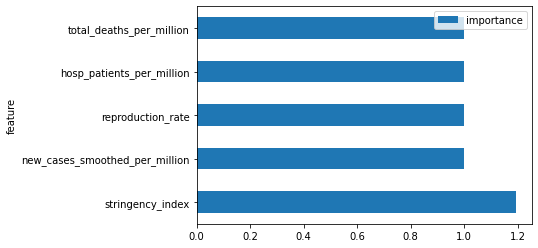

In [74]:

feature_names = ["new_cases_smoothed_per_million","reproduction_rate","total_deaths_per_million","stringency_index","hosp_patients_per_million"]
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
print(feature_importance)
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

## 10 PAISES

### Preprocesamiento

In [75]:
result = result.set_index('date')

In [76]:
result

,location,new_cases_smoothed_per_million,reproduction_rate,total_deaths_per_million,stringency_index,hosp_patients_per_million,Cuarentena
date,,,,,,,
2020-01-01,Argentina,0.00,0.00,0.00,0.00,0.00,0
2020-01-02,Argentina,0.00,0.00,0.00,0.00,0.00,0
2020-01-03,Argentina,0.00,0.00,0.00,0.00,0.00,0
2020-01-04,Argentina,0.00,0.00,0.00,0.00,0.00,0
2020-01-05,Argentina,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...
2022-06-26,United States,306.11,1.09,3015.16,26.49,83.45,0
2022-06-27,United States,334.62,1.09,3016.05,26.49,86.45,0
2022-06-28,United States,328.42,1.07,3017.73,26.48,87.69,0


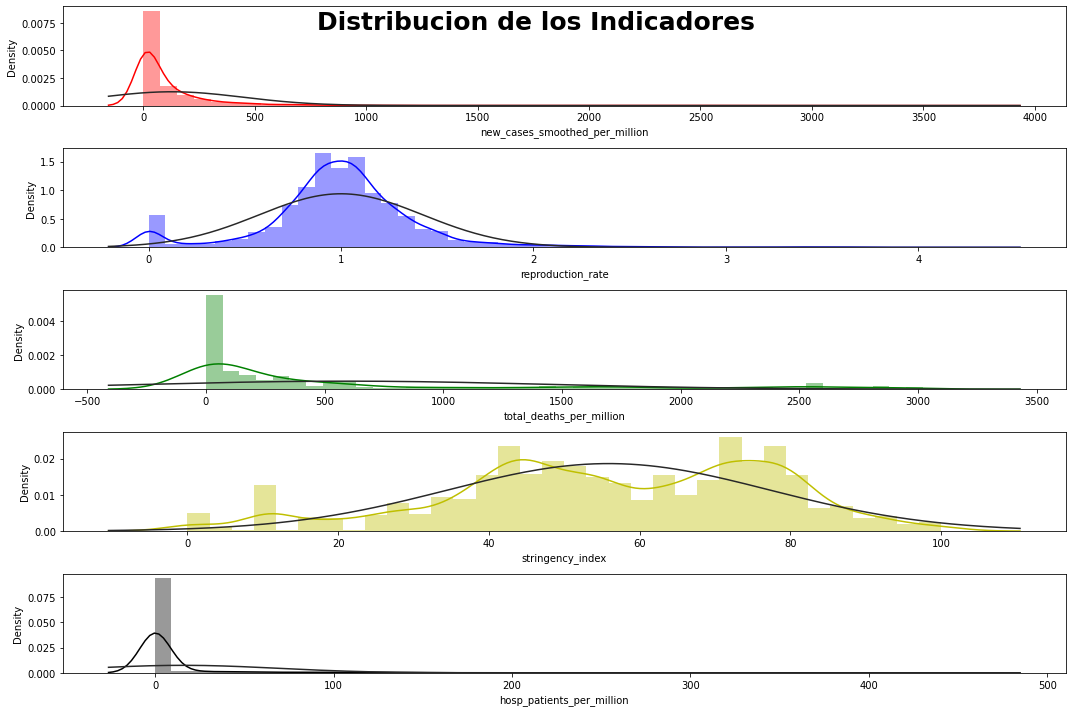

In [77]:
fig, axes = plt.subplots(5, figsize=(15,10))

fig.suptitle('Distribucion de los Indicadores', fontsize="25", fontweight="bold")

sns.distplot(ax=axes[0], a=result.new_cases_smoothed_per_million,fit=norm, kde=True,color= "r")
sns.distplot(ax=axes[1], a=result.reproduction_rate,fit=norm, kde=True, color= "b")
sns.distplot(ax=axes[2], a=result.total_deaths_per_million,fit=norm, kde=True,  color= "g")
sns.distplot(ax=axes[3], a=result.stringency_index,fit=norm, kde=True, color="y")
sns.distplot(ax=axes[4], a=result.hosp_patients_per_million,fit=norm, kde=True,  color= "k")

plt.tight_layout()

Modelo

In [78]:
result2 = result


In [79]:
result2

,location,new_cases_smoothed_per_million,reproduction_rate,total_deaths_per_million,stringency_index,hosp_patients_per_million,Cuarentena
date,,,,,,,
2020-01-01,Argentina,0.00,0.00,0.00,0.00,0.00,0
2020-01-02,Argentina,0.00,0.00,0.00,0.00,0.00,0
2020-01-03,Argentina,0.00,0.00,0.00,0.00,0.00,0
2020-01-04,Argentina,0.00,0.00,0.00,0.00,0.00,0
2020-01-05,Argentina,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...
2022-06-26,United States,306.11,1.09,3015.16,26.49,83.45,0
2022-06-27,United States,334.62,1.09,3016.05,26.49,86.45,0
2022-06-28,United States,328.42,1.07,3017.73,26.48,87.69,0


In [80]:
X = result2.drop(columns=["Cuarentena","location"])
y = result2.Cuarentena

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

In [82]:
logreg = LogisticRegression()
# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [83]:
model = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [84]:
model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [85]:
print("Tuned Hyperparameters :", model.best_params_)
print("Accuracy :",model.best_score_)

Tuned Hyperparameters : {'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy : 0.8796162707555414


In [86]:
logreg = LogisticRegression(**model.best_params_)
logreg.fit(X_train, y_train)

LogisticRegression(C=100.0, solver='liblinear')

In [87]:
y_test_pred = logreg.predict(X_test)
y_train_pred = logreg.predict(X_train)

AC SCORE TRAIN: 0.879290710915894
AC SCORE TEST: 0.886527514231499
F1 SCORE:  0.8867333293747142


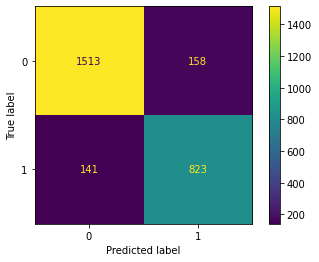

In [88]:
puntajes(X_test,X_train,y_test, y_test_pred, logreg)

In [89]:
score_arg = logreg.score(X_test, y_test)
w0 = logreg.intercept_[0]
w = w1, w2, w3, w4, w5 = logreg.coef_[0]
 
equation = "y = %f + (%f * x1) + (%f * x2) + (%f * x3) + (%f * x4) + (%f * x5)" % (w0, w1, w2, w3, w4, w5)
print(equation)

model_arg_ec = pd.DataFrame({"Pais":"Argentina","w0":[w0], "w1":[w1], "w2":[w2], "w3":[w3],"w4":[w4],"w5":[w5], "Score":[score_arg]})
model_arg_ec

y = -10.420955 + (-0.001269 * x1) + (0.046581 * x2) + (0.000614 * x3) + (0.155809 * x4) + (-0.002299 * x5)


,Pais,w0,w1,w2,w3,w4,w5,Score
0,Argentina,-10.42,-0.00,0.05,0.00,0.16,-0.00,0.89


                          feature  importance
3                stringency_index        1.17
1               reproduction_rate        1.05
2        total_deaths_per_million        1.00
0  new_cases_smoothed_per_million        1.00
4       hosp_patients_per_million        1.00


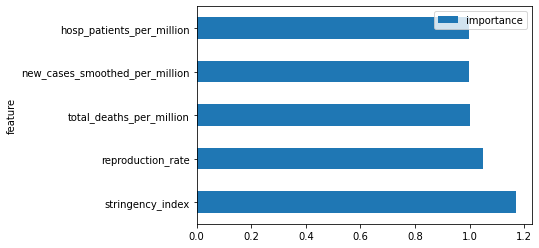

In [90]:
feature_names = ["new_cases_smoothed_per_million","reproduction_rate","total_deaths_per_million","stringency_index","hosp_patients_per_million"]
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
print(feature_importance)
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

Naive Bayes

In [91]:
gnb = GaussianNB()

In [92]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
model = GridSearchCV(gnb,                    # model
                   param_grid = params_NB,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
model.fit(X_train,y_train)
print(model.best_params_)
print(model.best_score_)

{'var_smoothing': 1.519911082952933e-07}
0.8166566033738514


AC SCORE TRAIN: 0.8181226614608752
AC SCORE TEST: 0.8208728652751424
F1 SCORE:  0.8237991499000963


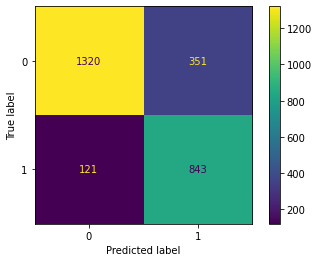

In [93]:
gnb = GaussianNB(**model.best_params_)
gnb.fit(X_train, y_train)
y_test_pred = gnb.predict(X_test)
y_train_pred = gnb.predict(X_train)
puntajes(X_test,X_train,y_test, y_test_pred, gnb)

In [94]:
# Prueba otros paises

In [95]:
OtrosPaises = ['Egypt', 'Germany', 'Russia', 'France', 'United Kingdom', 'South Korea', 'Nepal', 'Brazil', 'Nigeria', 'Andorra']

In [96]:
Prueba = DatosCovid[(DatosCovid.location.isin(OtrosPaises)) & (DatosCovid.date < "2022-07-01")]
Prueba = Prueba[["location","date","new_cases_smoothed_per_million","reproduction_rate","total_deaths_per_million","stringency_index","hosp_patients_per_million"]]

In [97]:
Prueba = pd.merge(Prueba, DatosMedida4, on=["location", "date"])
Prueba.date = pd.to_datetime(Prueba.date)

In [98]:
Prueba.stay_home_requirements.replace(1,0, inplace=True)
Prueba.stay_home_requirements.replace([3,2],1, inplace=True)

In [99]:
Prueba = Prueba.fillna(0)
Prueba = Prueba.rename(columns={'stay_home_requirements':'Cuarentena'
})
Prueba = Prueba.set_index('date')
Prueba

,location,new_cases_smoothed_per_million,reproduction_rate,total_deaths_per_million,stringency_index,hosp_patients_per_million,Cuarentena
date,,,,,,,
2020-03-02,Andorra,0.00,0.00,0.00,0.00,0.00,0
2020-03-03,Andorra,0.00,0.00,0.00,0.00,0.00,0
2020-03-04,Andorra,0.00,0.00,0.00,0.00,0.00,0
2020-03-05,Andorra,0.00,0.00,0.00,0.00,0.00,0
2020-03-06,Andorra,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...
2022-06-26,United Kingdom,257.75,1.19,2676.91,11.11,145.61,0
2022-06-27,United Kingdom,279.45,1.17,2678.15,11.11,152.58,0
2022-06-28,United Kingdom,290.03,1.12,2679.89,11.11,157.68,0


In [100]:
X_final = Prueba.drop(columns=["Cuarentena", "location"])
y_final = Prueba.Cuarentena

In [101]:
y_final_predict = logreg.predict(X_final)

In [102]:
from sklearn.metrics import accuracy_score
accuracy_score(y_final, y_final_predict)

0.8206242140162341

# Naive Bayes

In [103]:
y_final_predict = gnb.predict(X_final)
from sklearn.metrics import accuracy_score
accuracy_score(y_final, y_final_predict)

0.7401394763919058

Prueba Croacia

In [104]:
Prueba2 = DatosCovid[(DatosCovid.location.isin(['Croatia'])) & (DatosCovid.date < "2022-07-01")]
Prueba2 = Prueba2[["location","date","new_cases_smoothed_per_million","reproduction_rate","total_deaths_per_million","stringency_index","hosp_patients_per_million"]]
Prueba2 = Prueba2.set_index('date')
Prueba2 = Prueba2.fillna(0)

In [105]:
X_Croatia = Prueba2.drop(columns=["location"])
#y_Croatia = Prueba2.Cuarentena

In [106]:
y_final_predict = logreg.predict(X_Croatia)

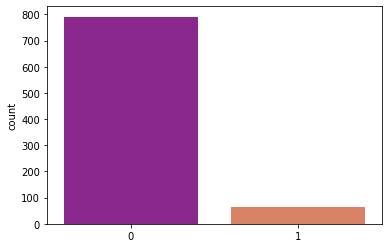

In [107]:
sns.countplot(x=y_final_predict,data=Prueba2,palette="plasma")
plt.show()

In [108]:
# Datos reales sobre cantidad de días con Cuarentena en Croacia
DatosMedida2[DatosMedida2.Entity.isin(['Croatia'])]

,Entity,stay_home_requirements,count
129,Croatia,0,765
130,Croatia,1,130
131,Croatia,2,49


# Conclusión

Podemos mencionar que nuestro modelo es bastante bueno, con un acuraccy de 0.82. Podría servir con una presición bastante alta cuando un país está o no haciendo cuarentena.


Y como podemos observar con la prueba de Crocia solo a predecido muy bien.

En todos los modelos pudimos notar que el indicador más relevante es el "stringency_index"

J.

Podríamos plantearnos las siguientes preguntas para seguir profundizando en el trabajo.

 - Cúal es el balance entre cuarentena y no cuarentena para que la ocupación de camas no supere el 80% ?

 - Existe una relacion en el aumento o dismunición de casos dentro de la no cuarentena y la estación del año?

 - Existe un índice de positive_rate Mayor o Menor dependiendo ubicación geografica de los países? (y todo lo que trae aparejado, cultura, religión, raza, etc)

## Informe


El trabajo se divide en 3 partes Cruciales.

La primer parte donde se toman 10 países y se evalua a traves de K como es la contagiosidad del virus en su "mejor" momento.

Se comparó este K al del mundo en general, el modelo realmente no fue adecuado ya que el mundo reacciono de maneras diversas y gran parte de la población estuvo de sobreaviso sobre la llegada del virus, lo que provocó grandes cuarentenas y dismunición del K a nivel global.

En la segunda parte se evalua la estrategía de hacer cuarentena.

Los modelos de Regresión logística se ajustan bastante bien, es alto su accuracy y predicen correctamente si un país está o no haciendo cuarentena. El indicador "stringency_index" ha sido el más relevante para el modelo.

En la tercera parte de investigación se prueban 10 países al Azar y se logra un accuracy del 0.89, lo que es muy bueno.
Se hace la prueba con un sólo país (Croacia) de forma gráfica y compara con la realidad y se nota un muy buen trabajo del modelo. Se puede afirmar que los modelos no están overfitiados ni underfitiado.

